In [1]:
!pip install tensorflow scikit-learn pandas matplotlib


  Using cached tensorflow-2.20.0-cp312-cp312-win_amd64.whl.metadata (4.6 kB)
  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached protobuf-6.32.0-cp310-abi3-win_amd64.whl.metadata (593 bytes)
  Using cached termcolor-3.1.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached grpcio-1.74.0-cp312-cp312-win_amd64.whl.metadata (4.0 kB)
  Using cached tensorboard-2.20.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached keras-3.11.3-py3-none-any.whl.metadata (5.9 kB)
  Using cached ml_dtypes-0.5.3-cp312-cp312-win_amd64.whl.metadata (9.2 kB)
  Using cach

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
streamlit 1.37.1 requires protobuf<6,>=3.20, but you have protobuf 6.32.0 which is incompatible.


In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [32]:
import pandas as pd

df = pd.read_csv("C:\\Users\\Admin\\OneDrive\\Desktop\\housing.csv")

# Clean the house_price column: remove $ and commas, then convert to float
df["House price (USD)"] = (
    df["House price (USD)"]
    .replace('[\\$,]', '', regex=True)   # remove $ and ,
    .astype(float)                      # convert to float
)

# Also clean house_area if it has commas
df["House area (sq. ft.)"] = (
    df["House area (sq. ft.)"]
    .replace('[\\$,]', '', regex=True)
    .astype(float)
)
df.head()

,Detail,House price (USD),House area (sq. ft.),Number of bedrooms,Number of bathrooms,image resolution,image path
0,Average,589360.0,2364.9,3.38,2.67,801x560,C:\Users\Admin\Downloads\100_bathroom.jpg
1,Minimum,22000.0,701.0,1.00,1.00,250x187,C:\Users\Admin\Downloads\102_bedroom.jpg
2,Maximum,5858000.0,9583.0,10.00,7.00,1484x1484,C:\Users\Admin\Downloads\151_frontal.jpg


In [33]:
# Feature setup
image_col  = "image path"
numeric_cols = ["House area (sq. ft.)", "Number of bedrooms", "Number of bathrooms"]
categorical_cols = []   # none for now
target_col = "House price (USD)"


In [34]:
X_tabular = df[numeric_cols].values
y = df[target_col].values

# Scale numeric features
scaler = StandardScaler()
X_tabular = scaler.fit_transform(X_tabular)

# Train-test split
X_tab_train, X_tab_test, y_train, y_test, img_train_paths, img_test_paths = train_test_split(
    X_tabular, y, df[image_col].values, test_size=0.2, random_state=42
)


In [35]:
IMG_SIZE = (128, 128)

def load_images(paths):
    images = []
    for path in paths:
        if os.path.exists(path):
            img = load_img(path, target_size=IMG_SIZE)  # Resize
            img = img_to_array(img) / 255.0            # Normalize
            images.append(img)
        else:
            print(f"Image not found: {path}")
            images.append(np.zeros((*IMG_SIZE, 3)))  # Placeholder if missing
    return np.array(images)

X_img_train = load_images(img_train_paths)
X_img_test = load_images(img_test_paths)

print("Image data shape:", X_img_train.shape)


Image data shape: (2, 128, 128, 3)


In [36]:
# Image branch (CNN)
image_input = layers.Input(shape=(*IMG_SIZE, 3))
x = layers.Conv2D(32, (3,3), activation="relu")(image_input)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Conv2D(64, (3,3), activation="relu")(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation="relu")(x)
image_features = layers.Dense(32, activation="relu")(x)

# Tabular branch (MLP)
tab_input = layers.Input(shape=(X_tab_train.shape[1],))
y = layers.Dense(32, activation="relu")(tab_input)
y = layers.Dense(16, activation="relu")(y)

# Combine both
combined = layers.concatenate([image_features, y])
z = layers.Dense(64, activation="relu")(combined)
z = layers.Dense(1)(z)  # Regression output

model = models.Model(inputs=[image_input, tab_input], outputs=z)
model.compile(optimizer="adam", loss="mse")
model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)    │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 126, 126, 32)      │             896 │ input_layer_8[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_5               │ (None, 63, 63, 32)        │               0 │ conv2d_5[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 61, 61, 64)        │          18,496 │ max_pooling2d_5[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_6               │ (None, 30, 30, 64)        │               0 │ conv2d_6[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_4 (Flatten)           │ (None, 57600)             │               0 │ max_pooling2d_6[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_9 (InputLayer)    │ (None, 3)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_15 (Dense)              │ (None, 64)                │       3,686,464 │ flatten_4[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_17 (Dense)              │ (None, 32)                │             128 │ input_layer_9[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_16 (Dense)              │ (None, 32)                │           2,080 │ dense_15[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_18 (Dense)              │ (None, 16)                │             528 │ dense_17[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_4 (Concatenate)   │ (None, 48)                │               0 │ dense_16[0][0],            │
│                               │                           │                 │ dense_18[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_19 (Dense)              │ (None, 64)                │           3,136 │ concatenate_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_20 (Dense)              │ (None, 1)                 │              65 │ dense_19[0][0]             │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 3,711,793 (14.16 MB)

 Trainable params: 3,711,793 (14.16 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
import numpy as np

# Convert tabular features to float
X_tab_train = X_tab_train.astype(np.float32)
X_tab_test  = X_tab_test.astype(np.float32)

# Convert image arrays to float
X_img_train = X_img_train.astype(np.float32)
X_img_test  = X_img_test.astype(np.float32)

# Convert target (y) to float and reshape
y_train = y_train.astype(np.float32).reshape(-1, 1)
y_test  = y_test.astype(np.float32).reshape(-1, 1)


In [38]:
history = model.fit(
    [X_img_train, X_tab_train], y_train,
    validation_data=([X_img_test, X_tab_test], y_test),
    epochs=5,
    batch_size=1
)


Epoch 1/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 489ms/step - loss: 17158312558592.0000 - val_loss: 347338571776.0000
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 17158291587072.0000 - val_loss: 347322974208.0000
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - loss: 17158220283904.0000 - val_loss: 347293712384.0000
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - loss: 17158012665856.0000 - val_loss: 347250491392.0000
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step - loss: 17157768347648.0000 - val_loss: 347179483136.0000


In [39]:
y_pred = model.predict([X_img_test, X_tab_test]).flatten()

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("MAE:", mae)
print("RMSE:", rmse)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
MAE: 589219.4
RMSE: 589219.4


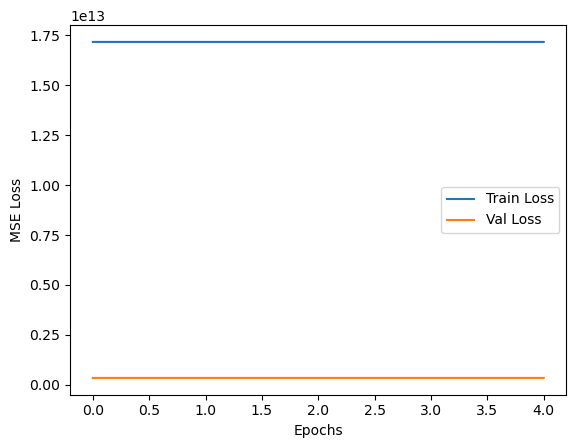

In [40]:
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()
